## Classifying Fashion-MNIST

You will have to create a classification model for the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) dataset, a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network.

In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Let's see a random sample

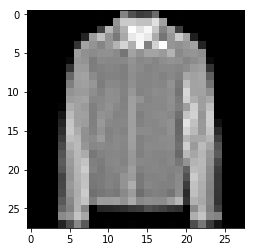

In [6]:
import helper
ind = np.random.permutation(X_train.shape[0])
plt.imshow(X_train[ind[0],:].reshape(28,28), cmap='gray');

Preparing the data for a training process...

In [5]:
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

input_dim = X_train.shape[1]

scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

# convert list of labels to binary class matrix
y_trainOHE = np_utils.to_categorical(y_train)
nb_classes = y_trainOHE.shape[1]

Using TensorFlow backend.


## Define the network architecture using keras

### Sequential models

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(32, input_shape=(input_dim,)),
    Activation('tanh'),
    Dense(nb_classes),
    Activation('softmax'),
])

or

In [104]:
del model
model = Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('tanh'))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dense(nb_classes, activation='softmax'))

**Assignment**: Take a look to the core layers in keras: https://keras.io/layers/core/ and the set of basic parameters https://keras.io/layers/about-keras-layers/

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


Once the arquictecture of model has been defined, the next step is to set the loss function and optimizer

In [105]:
# pass optimizer by name: default parameters will be used
model.compile(loss='categorical_crossentropy', optimizer='sgd')

from keras import optimizers
# or instantiate an optimizer before passing it to model.compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

Remember the definition of cross entropy:

$$\mathcal{L}({\bf{\hat{y}}},{\bf{y}}) = -\frac{1}{N}\sum_{i=1}^N y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$$

The categorical cross entropy can be defined as:

$$\mathcal{L}({\bf{\hat{y}}},{\bf{y}}) = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^C {\bf{1}}_{y_i \in C_j} \log p_{model}[y_i \in C_j]$$

The term ${\bf{1}}_{y_i \in C_j}$ is the indicator function of the $i$-th observation belonging to the $j$-th category. The $p_{model}[y_i \in C_j]$ is the probability predicted by the model for the $i$-th observation to belong to the $j$-th category. When there are more than two categories, the neural network outputs a vector of $C$ probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability $\hat{y}_i$, with the other one being $1$ minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it. 

**Note**. If insteat of a multi-class problem we would be facing a multi-label classification problem, the activation function of the last layer must be a **sigmoid** and the loss function **binary_crossentropy**.

Take a look to compile and fit parameters https://keras.io/models/model/#compile

In [106]:
print("Training...")
model.train_on_batch(X_trainN, y_trainOHE)

print("Generating test predictions...")
preds = model.predict(X_testN[0,:].reshape(1,input_dim), verbose=0)

Training...
Generating test predictions...


real class
9


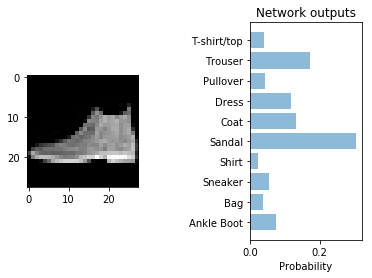

In [107]:
print('real class')
print(y_test[0])

objects = ('Ankle Boot', 'Bag', 'Sneaker', 'Shirt', 'Sandal', 'Coat', 'Dress', 'Pullover', 'Trouser', 'T-shirt/top')
y_pos = np.arange(nb_classes)
performance = preds.flatten()
plt.subplot(121)
plt.imshow(X_test[0,:].reshape(28,28), cmap='gray');
plt.subplot(122) 
plt.barh(y_pos[::-1], performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Network outputs')
plt.subplots_adjust(wspace = 1)
plt.show()

In [108]:
print("Training...")
model.fit(X_trainN, y_trainOHE, epochs=10, batch_size=16, validation_split=0.1, verbose=2)

Training...
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
 - 6s - loss: 0.4584 - val_loss: 0.3950
Epoch 2/10
 - 7s - loss: 0.3693 - val_loss: 0.3766
Epoch 3/10
 - 7s - loss: 0.3413 - val_loss: 0.3607
Epoch 4/10
 - 6s - loss: 0.3220 - val_loss: 0.3675
Epoch 5/10
 - 7s - loss: 0.3013 - val_loss: 0.3547
Epoch 6/10
 - 7s - loss: 0.2875 - val_loss: 0.3562
Epoch 7/10
 - 7s - loss: 0.2766 - val_loss: 0.3589
Epoch 8/10
 - 7s - loss: 0.2670 - val_loss: 0.3752
Epoch 9/10
 - 7s - loss: 0.2622 - val_loss: 0.3600
Epoch 10/10
 - 7s - loss: 0.2535 - val_loss: 0.3584


Generating test predictions...


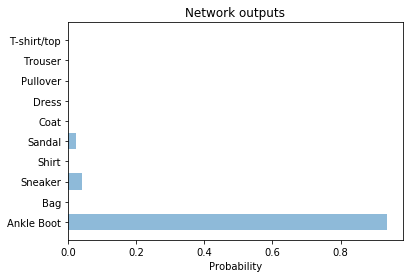

In [109]:
print("Generating test predictions...")
preds = model.predict(X_testN[0,:].reshape(1,input_dim), verbose=0)
performance = preds.flatten()
 
plt.barh(y_pos[::-1], performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Network outputs')
 
plt.show()

In [110]:
preds = model.predict_classes(X_testN, verbose=0)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Accuracy =  86.89 %


([<matplotlib.axis.YTick at 0x7f6ddd491470>,
 <a list of 10 Text yticklabel objects>)

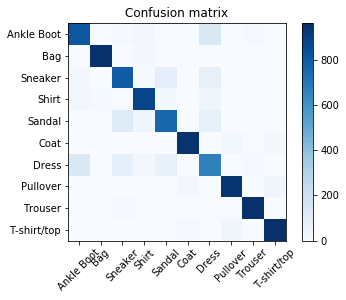

In [116]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
cmap = plt.cm.Blues
tick_marks = np.arange(nb_classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects)